#  Introduction
***
Over the past year Bitcoin has garnered a great deal of attention due to its ubiquitous media coverage, growth, and accessibility to buy and sell the digital currency.  With our generations willingness to openly and freely share information across social media platforms it’s an amazing time to delve into the influence social media may have on the fluctuations of Bitcoins value. In particular the sentiment of tweets pulled from twitter will be analyzed to gauge the influence the tweets may have on Bitcoins daily price. 


### Module Imports

In [49]:
%matplotlib inline

import pandas as pd
pd.set_option("display.max_rows",1000) #Changing default number of rows that are displayed in dataframe
pd.set_option('max_colwidth',-1) #Displaying max width of each column in dataframe


import numpy as np
import matplotlib.pyplot as plt
import re #Regular Expressions Module


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Part I: Tweet Preprocessing
***

At this point all tweets have been collected via twitters streaming api and saved as a csv file. In total approximately 3.6 million raw tweets were collected from 3/1/2018 to 3/14/2018.

### Loading In Streamed Tweets

In [50]:
#1) Loading in Extracted Twitter Data into a DataFrame
tweet_df = pd.read_csv("twitdb_3-1-18.csv", delimiter = '::::', names = ["time", "tweet", "lang", "fav_count", "follower_count"], engine='python',
                          error_bad_lines=False, warn_bad_lines=False)

#2) Converting Unix Timestamp to datetime
tweet_df["time"] = pd.to_datetime(tweet_df["time"], unit='s')

#3) Displaying entire width of each dataframe column
pd.set_option('max_colwidth',-1)

print("\nRaw tweets collected:\n")
display(tweet_df.head())
# display(tweet_df.info())


Raw tweets collected:



,time,tweet,lang,fav_count,follower_count
0,2018-03-01 20:17:13.294571000,"@iamjosephyoung pablo escobar clearly used bitcoin to sell cocaine in the USA, everyone knows that ! #knowyourfacts #pabloescobarcrypto"",""display_text_range"":[16,135]",en,1177,160
1,2018-03-01 20:17:14.114069000,"RT @COINTALKSHOW: Bill Miller, hedge fund god: Bitcoin is an innovation comparable to electricity, the radio and the Internet. \ud83d\udcaa\ud83d\udcaa\ud83d\udcaa\ud83d\udcaa https:\/\u2026""",en,452,27
2,2018-03-01 20:17:14.533954999,"RT @oksya34: #cryptocurrency #ICO #\u0431\u0430\u0443\u043d\u0442\u0438 #altcoin #bitcoin #bounty""",ru,36,1926
3,2018-03-01 20:17:14.933609000,"\u2139 Poloniex USDT- $XMR(5min) \n\n858.38% volume increase\n4.27% price increase\nPrice : 305.92499998\nNumber of mentions\u2026 https:\/\/t.co\/dJDMwX1sj9""",fr,0,1
4,2018-03-01 20:17:14.943077000,"Want to know what coin to hold?\n\nhttps:\/\/t.co\/4CsKgo3bmr\n\n$BTC $XLM $LBC $ADX $DGB $RDD $XEL $QRL $ARK $NXT $BLOCK\u2026 https:\/\/t.co\/5xIUPpJ1Nt"",""display_text_range"":[0,140]",en,0,184


### Investigating Tweets By Language

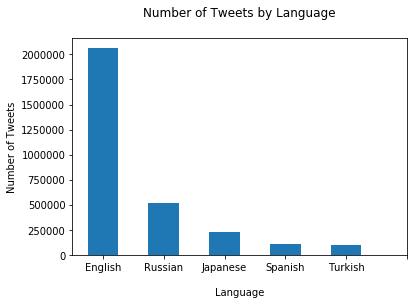

In [51]:
# Performing Value Counts on Categorical column
lang_count = tweet_df["lang"].value_counts()
# print(lang_count)

# Extracting top five rows or languages from series (languages are in ISO639-1 format)
top_five_lang = lang_count.iloc[0:5]
# print(top_five_lang)

#Plotting number of tweets by language
top_five_lang.plot(kind='bar')
plt.title("Number of Tweets by Language\n")
plt.xlabel("\nLanguage")
plt.ylabel("Number of Tweets")
plt.xticks([0,1,2,3,4,5], ['English', 'Russian', 'Japanese', 'Spanish', 'Turkish'], rotation=0)

plt.show()

### Filtering DataFrame to Hold Only English Language Tweets


In [52]:
tweet_df = tweet_df[tweet_df['lang']== 'en']

# display(tweet_df.info())

print("\nTweets filtered for english language:")
display(tweet_df.head())



Tweets filtered for english language:


,time,tweet,lang,fav_count,follower_count
0,2018-03-01 20:17:13.294571,"@iamjosephyoung pablo escobar clearly used bitcoin to sell cocaine in the USA, everyone knows that ! #knowyourfacts #pabloescobarcrypto"",""display_text_range"":[16,135]",en,1177,160
1,2018-03-01 20:17:14.114069,"RT @COINTALKSHOW: Bill Miller, hedge fund god: Bitcoin is an innovation comparable to electricity, the radio and the Internet. \ud83d\udcaa\ud83d\udcaa\ud83d\udcaa\ud83d\udcaa https:\/\u2026""",en,452,27
4,2018-03-01 20:17:14.943077,"Want to know what coin to hold?\n\nhttps:\/\/t.co\/4CsKgo3bmr\n\n$BTC $XLM $LBC $ADX $DGB $RDD $XEL $QRL $ARK $NXT $BLOCK\u2026 https:\/\/t.co\/5xIUPpJ1Nt"",""display_text_range"":[0,140]",en,0,184
8,2018-03-01 20:17:17.316209,"Jack Dorsey: Square Will Go Further With Bitcoin Than Buy\/Sell Option https:\/\/t.co\/PCrBuJEI6I""",en,24317,15038
9,2018-03-01 20:17:17.351142,"RT @COINTALKSHOW: Bill Miller, hedge fund god: Bitcoin is an innovation comparable to electricity, the radio and the Internet. \ud83d\udcaa\ud83d\udcaa\ud83d\udcaa\ud83d\udcaa https:\/\u2026""",en,2074,281


### Preprocessing Functions to Clean up Tweets

In [53]:
#1) Writing function with RegEx to pick up 

def tweet_preprocess1(tweet):
    """Feeding this fuction a tweet, it will look for string patterns and replace them with empty string.
    See comments in 'regex_str' list to see patterns that are being searched for."""
    
    #a) Replacing new lines and stripping tweet
    tweet_entry = tweet.replace('\n', '').strip()
    
    #b) Defining List of Regular Expressions
    regex_str = [
        r'\,?\"\w+\"\:\[\d+\,\d+\]', # Finds: ,"display_text_range":[16,135]
        r'(RT\s)?\@\w+\:?', #Finds: RT @name or @name or RT @name:
        r'https:\W+\w+\"?(\.\w+\W+\w+\")*', #Finds: https:\/\/t.co\/abcD9 or https:\/\/t.co\/abcD9" or https:\/\u2026"
        r'(\\ud)[a-z0-9]+',#Finds Java Escaped emojis: \ud83d\udcaa\ud83d\udcaa
        r'\\\w+' #Finds \u2026 
        ]
    
    #c) Joining & Compiling Multiple RegEx Patterns to look for in tweet
    giant_regex = re.compile(r'('+'|'.join(regex_str)+')')
    
    #d) Substituting found RegEx patterns in tweet with ''
    tweet_processed = processed_tweet = re.sub(giant_regex,'', tweet_entry)
    
    #e) Returning Processed Tweet
    return tweet_processed


#2) Writing function to convert all text to lowercase and only keep letters

def tweet_preprocess2(tweet):
    
    
    #b) Splitting sentence into individual words & converting to lowercase
    words = tweet.lower().split() #returns a list
    
    #c) Looping thru each word and letter to see if in a-z
    s = ""#initializing empty string
    
    for word in words: #pulls word out of list
        
        for letter in word:#goes thru each letter of word
            
            if letter in "abcdefghijklmnopqrstuvwxyz":#checks if letter is one of these characters
                s = s + letter #if letter adds to variable
        
        s = s + " " #once word is reassembled, puts space at end
        
    return s

    

### Applying Function to Preprocess Tweets in DataFrame

In [54]:
#1) Applying First Preprocessing Function to Raw Tweets
tweet_df['tweet'] = tweet_df['tweet'].apply(tweet_preprocess1) 

#2) Applying Second Preprocessing Function to Raw Tweets
tweet_df['tweet'] = tweet_df['tweet'].apply(tweet_preprocess2) 

print("\nDataFrame Holding Cleaned up Tweets:")
display(tweet_df.head())




DataFrame Holding Cleaned up Tweets:


,time,tweet,lang,fav_count,follower_count
0,2018-03-01 20:17:13.294571,pablo escobar clearly used bitcoin to sell cocaine in the usa everyone knows that knowyourfacts pabloescobarcrypto,en,1177,160
1,2018-03-01 20:17:14.114069,bill miller hedge fund god bitcoin is an innovation comparable to electricity the radio and the internet,en,452,27
4,2018-03-01 20:17:14.943077,want to know what coin to holdtcocskgobmrbtc xlm lbc adx dgb rdd xel qrl ark nxt block,en,0,184
8,2018-03-01 20:17:17.316209,jack dorsey square will go further with bitcoin than buysell option,en,24317,15038
9,2018-03-01 20:17:17.351142,bill miller hedge fund god bitcoin is an innovation comparable to electricity the radio and the internet,en,2074,281


# Part 2: Sentiment Analysis Tuning with Vader & TextBlob
***
In this section Vader & Textblob Sentiment Analyzers will be tuned using a prelabled tweet dataset from thinknook.com. 

**Warning: Code is commented out becuase it takes signifiant amout of time to run** 

### Functions to Tune & Classify Sentiment of Tweets

In [55]:
def sentiment_labeler_vader(tweet, threshold=.02):
    
    """Given a particular 'tweet' and 'threshold', a tweet
    will be classified as either positive (1) or negative (0)
    using Vader Sentiment Analysis.
    Neutral tweets will be assigned a Nan label."""
    
    #1) Initializing Vader Sentiment Analyzer Object
    sentiment_analyzer = SentimentIntensityAnalyzer()
    
    #2) Estimating Tweets Polarity
    tweet_polarity = sentiment_analyzer.polarity_scores(tweet)
    
    #3) Assigning Sentiment Labels Based on Specific Polarity Threshold
    
    if tweet_polarity['compound'] > threshold:
        
        sentiment = 1 #positive label

    elif tweet_polarity['compound'] < - threshold:
        
        sentiment = 0 #negative label

    else:
        sentiment = np.nan #label in neutral zone
    
    #4) Returning Sentiment Label for Specific Tweet
    return sentiment


def sentiment_labeler_textblob(tweet, threshold=.02):
    
    """Given a particular 'tweet' and 'threshold', a tweet
    will be classified as either positive (1) or negative (0)
    using TextBlob.
    Neutral tweets will be assigned a Nan label."""
    
    #1) Initializing Vader Sentiment Analyzer Object
    sentiment_analyzer = TextBlob(tweet)
    
    #2) Estimating Tweets Polarity
    tweet_polarity = sentiment_analyzer.sentiment.polarity
    
    #3) Assigning Sentiment Labels Based on Specific Polarity Threshold
    
    if tweet_polarity > threshold:
        
        sentiment = 1 #positive label

    elif tweet_polarity < - threshold:
        
        sentiment = 0 #negative label

    else:
        sentiment = np.nan #label in neutral zone
    
    #4) Returning Sentiment Label for Specific Tweet
    return sentiment


def sentiment_accuracy(original_labels, predicted_labels):
    """ Enter list or array of 'original' and 'predicted' labels
    and returns accuracy of sentiment classifer along with the remaining
    number of samples (Neutral sentiments are dropped)"""
    
    #2) Initializing & Creating DataFrame to Hold Original & Predicted Labels
    label_comparison_df = pd.DataFrame({"Original_Label": original_labels, "Predicted_Label": predicted_labels})
    
    #3) Dropping Nans (approximate neutral predictions)#going to be a lot of them
    label_comparison_df.dropna(inplace=True)
    
    #4) Row_wise Check to see which predictions are correct
    label_comparison_df["Compare"] = np.where(label_comparison_df['Original_Label'] == label_comparison_df['Predicted_Label'], True, False)
    
    #5) Calculating Accuracy
    num_samples_after_drop = len(label_comparison_df["Compare"])
    
    accuracy = label_comparison_df['Compare'].sum()/num_samples_after_drop
    
    #6) Returning Accuracy & Number of Samples Left
    return(accuracy, num_samples_after_drop)

### Performance Assessment with General Labeled Data set from Thinknook.com

In [56]:
# #1) Local Path to ThinkNook Data Set
# filename = "./Sentiment-Analysis-Dataset/SentimentAnalysisDataset.csv"

# #2) Loading data into DataFrame
# twitter_sent_df = pd.read_csv(filename, delimiter=',', error_bad_lines=False, warn_bad_lines=False, usecols=["Sentiment", 'SentimentText'], nrows=10000)

# # display(twitter_sent_df.head())


### Preprocessing Thinknook Tweets

In [57]:
# twitter_sent_df["SentimentText"] = twitter_sent_df["SentimentText"].apply(tweet_preprocess2)

# display(twitter_sent_df.head())

### Optimizing Sentiment Label Classifiers - Vader

In [58]:
# #Extracting Original Labels
# original_labels = twitter_sent_df['Sentiment'].values


# accuracies_and_remaining_samples = [] #Collects all accuracies & number of samples for a particular 'threshold'

# for threshold in np.arange(0,.5,.01):#varying threshold to find optimal parameters for sentiment labelling

#     predicted_labels = []

#     for tweet in list(twitter_sent_df['SentimentText'].values): #Running thru each tweet and labelling

#         pred_label = sentiment_labeler_vader(tweet, threshold) #Function that labels tweet

#         #need to make list to store all label  predictions
#         predicted_labels.append(pred_label)

    
#     accuracy_and_sample = sentiment_accuracy(original_labels, predicted_labels)#Function to calculate accuracy and drop neutral sentimets
#     accuracies_and_remaining_samples.append(accuracy_and_sample)
    
    
# #printing predicted_labels
# print(accuracies_and_remaining_samples)

### Optimizing Sentiment Label Classifiers - TextBlob

In [59]:
# #Extracting Original Labels
# original_labels = twitter_sent_df['Sentiment'].values


# accuracies_and_remaining_samples_textblob = [] #Collects all accuracies & number of samples for a particular 'threshold'

# for threshold in np.arange(0,.5,.01):#varying threshold to find optimal parameters for sentiment labelling

#     predicted_labels_textblob = []

#     for tweet in list(twitter_sent_df['SentimentText'].values): #Running thru each tweet and labelling

#         pred_label = sentiment_labeler_textblob(tweet, threshold) #Function that labels tweet

#         #need to make list to store all label  predictions
#         predicted_labels_textblob.append(pred_label)

    
#     accuracy_and_sample = sentiment_accuracy(original_labels, predicted_labels_textblob)#Function to calculate accuracy and drop neutral sentimets
#     accuracies_and_remaining_samples_textblob.append(accuracy_and_sample)
    
    
# #printing predicted_labels
# print(accuracies_and_remaining_samples_textblob)

### Performance of Each Sentiment Classifier - General DataSet from Thinknook



In [60]:
# #1) Extracting Accuracies & Samples From Tuples Generated Above

# #a) Vader
# accuracies_vader = [acc[0] for acc in accuracies_and_remaining_samples]
# samples_remaining_vader = [samp[1] for samp in accuracies_and_remaining_samples]


# #b) TextBlob
# accuracies_textblob = [acc[0] for acc in accuracies_and_remaining_samples_textblob]
# samples_remaining_textblob = [samp[1] for samp in accuracies_and_remaining_samples_textblob]


# #2) Plotting Performance of Vader & TextBlob

# #a) Plotting Sentiment Performance for Both Methods
# plt.scatter(accuracies_vader, samples_remaining_vader, label="Vader")
# plt.scatter(accuracies_textblob, samples_remaining_textblob, marker = 's', c='r', label="TextBlob" )

# #b) Plotting Horizontal Line Indicating Intial Number of Samples
# plt.axhline(y=twitter_sent_df.shape[0], color='g', linestyle = '--', label='Intitial Number Samples')


# plt.xlabel("Accuracy")
# plt.ylabel("Samples Remaining")
# plt.title("Sentiment Performance (ThinkNook Data)\n")
# plt.legend( loc = (.5,.65))

# plt.show()

### Picking Out Optimal Model & Parameters To Classify Bitcoin Tweets

1) Optimal Model Parameters are Dependent on How Many Samples You Are Willing to Throw Out to Maintain a Particular Accuracy

* Vader Selected as Optimal Sentiment Analyzer with threshold=.2, number of samples = 6171, and an accuracy = .725

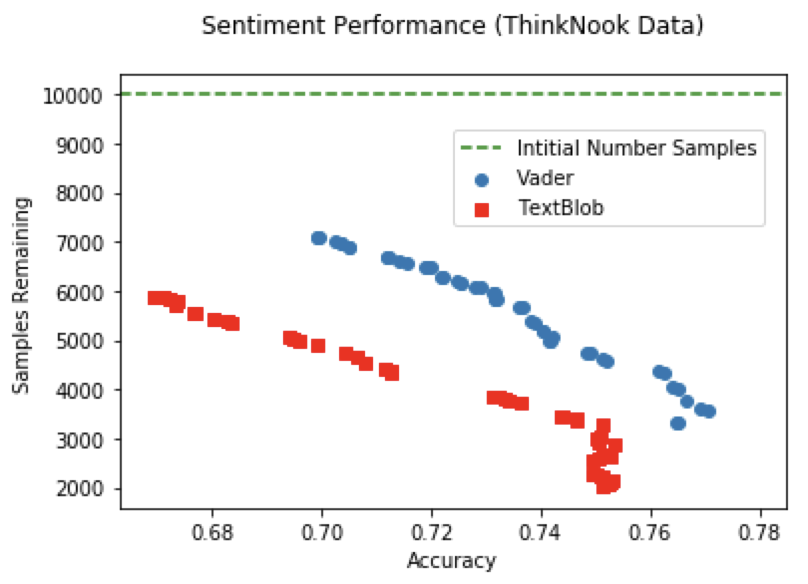



# Part III: Bitcoin Sentiment Analysis with Optimal Model
***

### Running Bitcoin Tweets Thru Optimal Sentiment Analyzer (Vader)

**Warning: Code is commented out due to significantly long run times**

In [61]:
# #1) Applying Vader Sentiment Labeler to Bitcoin Data Set (threshold=.2)

# tweet_analyzer_optimal = tweet_df['tweet'].apply(sentiment_labeler_vader)

# display(tweet_analyzer_optimal.head())

In [62]:
# #2) Adding In Labelled Tweets into Orignal DataFrame to Align Text of Tweet and Their Predicted Labels

# tweet_df['pred_label'] = tweet_analyzer_optimal

# display(tweet_df.head())


### Outputting DataFrame with Predicted Labels

In [63]:
# import csv

# tweet_df.to_csv("tweet_df__analyzer_optimal_results.txt", index=False, quoting=csv.QUOTE_NONE, escapechar=" ")

## Temporary Load of tweet_df - Because Super Long Run Time

* Positive tweet = 1
* Negative tweet = 0
* Neutral tweet = NaN

In [64]:
tweet_df = pd.read_csv('tweet_df__analyzer_optimal_results.txt', parse_dates=['time']) #loading in to avoid super long run times

tweet_df['tweet'] = tweet_df['tweet'].astype(str)
# display(tweet_df.info())
print("\nLabeled Bitcoin Tweets with Vader:")
display(tweet_df.head())



Labeled Bitcoin Tweets with Vader:


,time,tweet,lang,fav_count,follower_count,pred_label
0,2018-03-01 20:17:13.294571,pablo escobar clearly used bitcoin to sell cocaine in the usa everyone knows that knowyourfacts pabloescobarcrypto,en,1177,160,1.0
1,2018-03-01 20:17:14.114069,bill miller hedge fund god bitcoin is an innovation comparable to electricity the radio and the internet,en,452,27,1.0
2,2018-03-01 20:17:14.943077,want to know what coin to holdtcocskgobmrbtc xlm lbc adx dgb rdd xel qrl ark nxt block,en,0,184,0.0
3,2018-03-01 20:17:17.316209,jack dorsey square will go further with bitcoin than buysell option,en,24317,15038,NaN
4,2018-03-01 20:17:17.351142,bill miller hedge fund god bitcoin is an innovation comparable to electricity the radio and the internet,en,2074,281,1.0


### Investigating Number of Positive, Negative, and Neutral Tweets


Total Number of Bitcoin Tweets Sampled: 2061723


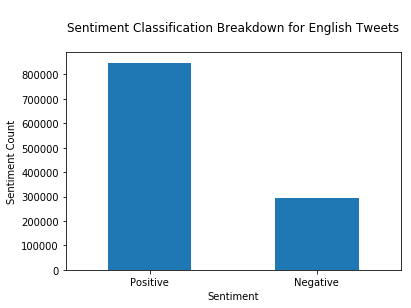

In [65]:
#1) Showing Intial Number of Samples We Started With (Filtered By English Language)
print("\nTotal Number of Bitcoin Tweets Sampled:", tweet_df.shape[0])

#Note: becuase dataframe was filtered for 'english' language tweets, the number
#here will differ from what we started with (Intial start: 750000, After English Filter: ~431000)

#2) Finding Breakdown of Predicted Labels Using Vader
tweet_sentiment_count = tweet_df["pred_label"].value_counts()

# print("\nThis is a Breakdown of Predicted Labels By Sentiment (1 = Positive, 0=Negative):\n")
# display(tweet_sentiment_count)


tweet_sentiment_count.plot(kind='bar')
plt.xticks([0,1],['Positive', 'Negative'], rotation=0)
plt.xlabel("Sentiment")
plt.ylabel("Sentiment Count")
plt.title("\nSentiment Classification Breakdown for English Tweets\n")
plt.show()

### Downsampling Tweets & Aggregating Sentiments Into 15 Minute Intervals 

In [66]:
#1) Extracting only time and sentiment columns
tweet_df_downsamp_and_agg = tweet_df[["time", "pred_label", "fav_count", "follower_count"]]

#2) Setting 'time' column as the datetimeindex
tweet_df_downsamp_and_agg.set_index('time', inplace=True)

#3) Downsampling tweet data into 15 min intervals and aggregating 
tweet_df_downsamp_and_agg = tweet_df_downsamp_and_agg.resample('15T').agg({'pred_label':['sum','count'],"fav_count":'mean', "follower_count": 'mean'})

#a) Renaming aggregated column
tweet_df_downsamp_and_agg.columns = ["pos_sentiment", 'total_tweets', 'favorited_avg', 'followers_avg']


#4) Adding in Count of negative tweets
tweet_df_downsamp_and_agg['neg_sentiment'] = tweet_df_downsamp_and_agg['total_tweets'] - tweet_df_downsamp_and_agg['pos_sentiment']


#5) Adding in a column defining the ratio of postive to negative sentiments
tweet_df_downsamp_and_agg['pos_to_neg_ratio'] = tweet_df_downsamp_and_agg['pos_sentiment']/ tweet_df_downsamp_and_agg['neg_sentiment']


#6) Rearranging Columns
tweet_df_downsamp_and_agg = tweet_df_downsamp_and_agg[['pos_sentiment', 'neg_sentiment','pos_to_neg_ratio', 'total_tweets', 'favorited_avg', 'followers_avg']]

print("\nResampling Tweets into 15 minute intervals:")
display(tweet_df_downsamp_and_agg.head())
# display(tweet_df_downsamp_and_agg.info())


Resampling Tweets into 15 minute intervals:


,pos_sentiment,neg_sentiment,pos_to_neg_ratio,total_tweets,favorited_avg,followers_avg
time,,,,,,
2018-03-01 20:15:00,608.0,209.0,2.909091,817,5754.968525,8461.403279
2018-03-01 20:30:00,765.0,205.0,3.731707,970,5335.484645,6742.339475
2018-03-01 20:45:00,164.0,51.0,3.215686,215,5148.629428,3415.438692
2018-03-01 21:00:00,NaN,NaN,NaN,0,NaN,NaN
2018-03-01 21:15:00,520.0,152.0,3.421053,672,7250.560870,5844.790435


# Part IV: Bitcoin Price Changes 
***

### Loading in Bitcoin Price Data

In [67]:
#1) Loading Bitcoin Price Data from CSV

#a) 15 Minute Intervals with Volume (BTC), Volume(Currency), Weighted Price shifted back one time interval (Goal is to predict the future)
bitcoin_15min_df = pd.read_csv('./BitcoinData/bitcoin_15min_2-27_to_3-15.csv',index_col='Timestamp', parse_dates=True)

print("\nThis is Bitcoin Data Over 15 Min Intervals:")
display(bitcoin_15min_df.head())


This is Bitcoin Data Over 15 Min Intervals:


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Timestamp,,,,,,,
2018-02-27 00:00:00,10329.99,10355.22,10318.00,10324.11,72.76,752260.61,10339.31
2018-02-27 00:15:00,10333.13,10365.78,10303.62,10353.76,86.21,890497.00,10329.52
2018-02-27 00:30:00,10353.82,10410.00,10334.51,10407.96,105.78,1097655.15,10376.63
2018-02-27 00:45:00,10407.99,10419.89,10359.35,10369.99,140.03,1455325.21,10393.23
2018-02-27 01:00:00,10369.99,10409.07,10345.84,10354.53,67.77,702379.81,10364.74


### Function to Calculate Bitcoin Price Changes 

In [68]:
def price_change_df(bitcoin_price_interval_df):
    
    """This is a function to caluclate price changes for bitcoin datframes with 
    different time intervals or frequencies.It returns a new dataframe with calculated
    price changes on Bitcoins trading volume."""
    
    #1) Calculating 'Close' minus 'Open' & Adding in Results as New Column
    bitcoin_price_interval_df['Price_Change_CO'] = bitcoin_price_interval_df['Close'] - bitcoin_price_interval_df['Open']
    
    #2) Calculating 'High' minus 'Low' & Adding in Results as New Column
    bitcoin_price_interval_df['Price_Change_HL'] = bitcoin_price_interval_df['High'] - bitcoin_price_interval_df['Low']
    
    #3) Selecting Columns of Need
    bitcoin_price_interval_df_to_join = bitcoin_price_interval_df[['Volume (BTC)', 'Price_Change_CO', 'Price_Change_HL']]
    
    return bitcoin_price_interval_df_to_join


### Applying Function to Calculate Price Changes

In [69]:
#1) Applying Function to Calculate Price Changes over Differnt Time Intervals

#a) 15 Minute Intervals
bitcoin_15min_df = price_change_df(bitcoin_15min_df)

print("Bitcoin Price Changes Over 15 Minute Intervals:")

display(bitcoin_15min_df.head())



Bitcoin Price Changes Over 15 Minute Intervals:


,Volume (BTC),Price_Change_CO,Price_Change_HL
Timestamp,,,
2018-02-27 00:00:00,72.76,-5.88,37.22
2018-02-27 00:15:00,86.21,20.63,62.16
2018-02-27 00:30:00,105.78,54.14,75.49
2018-02-27 00:45:00,140.03,-38.00,60.54
2018-02-27 01:00:00,67.77,-15.46,63.23


# Part V: Tweet Sentiments & Price Data Joined
***

### Joining Twitter and Price Data over 15 Min Intervals

Joined Twitter & Bitcoin DataFrame (15 Minute Intervals):


,pos_sentiment,neg_sentiment,pos_to_neg_ratio,total_tweets,favorited_avg,followers_avg,Volume (BTC),Price_Change_CO,Price_Change_HL
2018-03-01 20:15:00,608.0,209.0,2.909091,817,5754.968525,8461.403279,307.51,79.89,84.74
2018-03-01 20:30:00,765.0,205.0,3.731707,970,5335.484645,6742.339475,332.25,-15.83,65.67
2018-03-01 20:45:00,164.0,51.0,3.215686,215,5148.629428,3415.438692,270.58,64.69,115.63
2018-03-01 21:00:00,NaN,NaN,NaN,0,NaN,NaN,186.92,-36.04,99.22
2018-03-01 21:15:00,520.0,152.0,3.421053,672,7250.560870,5844.790435,71.93,-18.90,76.57


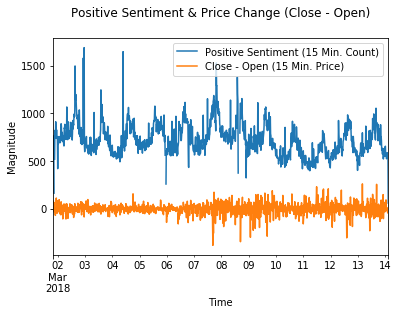

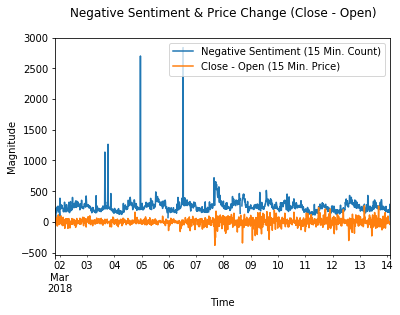

In [77]:
#1) Merging or Joining DataFrames (Inner Join)
twitter_price_15min_df = pd.merge(tweet_df_downsamp_and_agg, bitcoin_15min_df, left_index=True, right_index=True)


#2) Displaying Joined DataFrame
print("Joined Twitter & Bitcoin DataFrame (15 Minute Intervals):")
display(twitter_price_15min_df.head())
# display(twitter_price_15min_df.info())


#3) Investigating General Sentiment and Price Changes 

#a) Price Change (Close-Open) & Positive Sentiment
twitter_price_15min_df[['pos_sentiment', 'Price_Change_CO']].plot()
plt.legend(["Positive Sentiment (15 Min. Count)", "Close - Open (15 Min. Price)"], loc='upper right')
plt.title('Positive Sentiment & Price Change (Close - Open)\n')
plt.xlabel("Time"), plt.ylabel("Magnitude")

#b) Price Change (Close-Open) & Negative Sentiment
twitter_price_15min_df[['neg_sentiment', 'Price_Change_CO']].plot()
plt.legend(["Negative Sentiment (15 Min. Count)", "Close - Open (15 Min. Price)"], loc='upper right')
plt.title('Negative Sentiment & Price Change (Close - Open)\n')
plt.xlabel("Time"), plt.ylabel("Magnitude")

# #c) Price Change (High-Low) & Positive Sentiment
# twitter_price_15min_df[['pos_sentiment', 'Price_Change_HL']].plot()
# plt.legend(["Positive Sentiment (15 Min. Count)", "High - Low (15 Min. Price)"], loc='upper right')
# plt.title('Positive Sentiment & Price Change (High - Low)\n')
# plt.xlabel("Time"), plt.ylabel("Magnitude")

# #d) Price Change(High-Low) & Negative Sentiment
# twitter_price_15min_df[['neg_sentiment', 'Price_Change_HL']].plot()
# plt.title('Negative Sentiment & Price Change (High - Low)\n')
# plt.legend(["Negative Sentiment (15 Min. Count)", "High - Low (15 Min. Price)"], loc='upper right')
# plt.xlabel("Time"), plt.ylabel("Magnitude")

plt.show()


#******filling NaN's in DF with Zeroes******
twitter_price_15min_df.fillna(0, inplace=True)



### Lagging All Prices  by 1 Time Interval (goal is predict future)

In [68]:
print("Original dataframe with all features aligned correctly:\n")
display(twitter_price_15min_df.head())

print("Augmented dataframe with all features shifted back 15 mins:")
twitter_price_15min_df[['Price_Change_CO', 'Price_Change_HL']] = twitter_price_15min_df[['Price_Change_CO', 'Price_Change_HL']].shift(periods=-1)
display(twitter_price_15min_df.head())

twitter_price_15min_df.dropna(inplace=True)
# display(twitter_price_15min_df.tail())

Original dataframe with all features aligned correctly:



,pos_sentiment,neg_sentiment,pos_to_neg_ratio,total_tweets,favorited_avg,followers_avg,Volume (BTC),Price_Change_CO,Price_Change_HL
2018-03-01 20:15:00,608.0,209.0,2.909091,817,5754.968525,8461.403279,307.51,-15.83,65.67
2018-03-01 20:30:00,765.0,205.0,3.731707,970,5335.484645,6742.339475,332.25,64.69,115.63
2018-03-01 20:45:00,164.0,51.0,3.215686,215,5148.629428,3415.438692,270.58,-36.04,99.22
2018-03-01 21:00:00,0.0,0.0,0.000000,0,0.000000,0.000000,186.92,-18.90,76.57
2018-03-01 21:15:00,520.0,152.0,3.421053,672,7250.560870,5844.790435,71.93,8.71,45.31


Augmented dataframe with all features shifted back 15 mins:


,pos_sentiment,neg_sentiment,pos_to_neg_ratio,total_tweets,favorited_avg,followers_avg,Volume (BTC),Price_Change_CO,Price_Change_HL
2018-03-01 20:15:00,608.0,209.0,2.909091,817,5754.968525,8461.403279,307.51,64.69,115.63
2018-03-01 20:30:00,765.0,205.0,3.731707,970,5335.484645,6742.339475,332.25,-36.04,99.22
2018-03-01 20:45:00,164.0,51.0,3.215686,215,5148.629428,3415.438692,270.58,-18.90,76.57
2018-03-01 21:00:00,0.0,0.0,0.000000,0,0.000000,0.000000,186.92,8.71,45.31
2018-03-01 21:15:00,520.0,152.0,3.421053,672,7250.560870,5844.790435,71.93,-65.74,125.14


### Plots of Sentiment and Lag (15 Min)

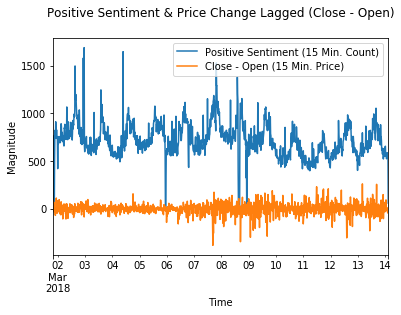

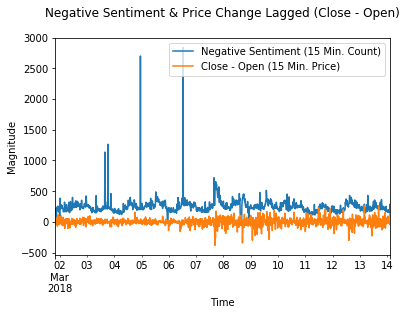

In [78]:

#3) Investigating General Sentiment and Price Changes 

#a) Price Change (Close-Open) & Positive Sentiment
twitter_price_15min_df[['pos_sentiment', 'Price_Change_CO']].plot()
plt.legend(["Positive Sentiment (15 Min. Count)", "Close - Open (15 Min. Price)"], loc='upper right')
plt.title('Positive Sentiment & Price Change Lagged (Close - Open)\n')
plt.xlabel("Time"), plt.ylabel("Magnitude")

#b) Price Change (Close-Open) & Negative Sentiment
twitter_price_15min_df[['neg_sentiment', 'Price_Change_CO']].plot()
plt.legend(["Negative Sentiment (15 Min. Count)", "Close - Open (15 Min. Price)"], loc='upper right')
plt.title('Negative Sentiment & Price Change Lagged (Close - Open)\n')
plt.xlabel("Time"), plt.ylabel("Magnitude")

# #c) Price Change (High-Low) & Positive Sentiment
# twitter_price_15min_df[['pos_sentiment', 'Price_Change_HL']].plot()
# plt.legend(["Positive Sentiment (15 Min. Count)", "High - Low (15 Min. Price)"], loc='upper right')
# plt.title('Positive Sentiment & Price Change Lagged (High - Low)\n')
# plt.xlabel("Time"), plt.ylabel("Magnitude")

# #d) Price Change(High-Low) & Negative Sentiment
# twitter_price_15min_df[['neg_sentiment', 'Price_Change_HL']].plot()
# plt.title('Negative Sentiment & Price Change Lagged (High - Low)\n')
# plt.legend(["Negative Sentiment (15 Min. Count)", "High - Low (15 Min. Price)"], loc='upper right')
# plt.xlabel("Time"), plt.ylabel("Magnitude")

plt.show()

### Scaling Data

In [72]:
from sklearn import preprocessing

#1)Dropping entire rows with NaNs (No tweets counted for particular bin)
twitter_price_15min_df.dropna(inplace=True)

#Using Min-Max Scaler to scale cleaned DF with Sentiment Counts and Daily Price Changes

#1-a) Instantiating Scaler
scaler = preprocessing.MinMaxScaler()

#2) Scaling entire dataframe -- Scaler Returns a numpy array
scaled_df = scaler.fit_transform(twitter_price_15min_df)

#3) Converting Numpy Array back to a Pandas DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=twitter_price_15min_df.columns)

print("This is scaled version of Sentiment Counts & Price Changes DataFrame:")
display(scaled_df.head())

This is scaled version of Sentiment Counts & Price Changes DataFrame:


,pos_sentiment,neg_sentiment,pos_to_neg_ratio,total_tweets,favorited_avg,followers_avg,Volume (BTC),Price_Change_CO,Price_Change_HL
0,0.359763,0.073721,0.384819,0.230141,0.447402,0.253371,0.132533,0.718100,0.163969
1,0.452663,0.072310,0.493636,0.273239,0.414791,0.201895,0.143288,0.569497,0.120976
2,0.097041,0.017989,0.425376,0.060563,0.400264,0.102273,0.116480,0.694503,0.233610
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080112,0.538121,0.196614
4,0.307692,0.053616,0.452542,0.189296,0.563672,0.175019,0.030125,0.564731,0.145550


### Pearson Correlation


Pearson Correlation Results (15min):


,pos_sentiment,neg_sentiment,pos_to_neg_ratio,total_tweets,favorited_avg,followers_avg,Volume (BTC),Price_Change_CO
pos_sentiment,1.000000,0.386135,0.314904,0.881266,0.077212,0.219203,0.175409,-0.050231
neg_sentiment,0.386135,1.000000,-0.375408,0.776253,-0.079237,0.081560,0.179132,-0.005430
pos_to_neg_ratio,0.314904,-0.375408,1.000000,0.022870,0.169685,0.018721,-0.165725,0.000554
total_tweets,0.881266,0.776253,0.022870,1.000000,0.012171,0.191597,0.211659,-0.037111
favorited_avg,0.077212,-0.079237,0.169685,0.012171,1.000000,0.211624,0.054607,0.006050
followers_avg,0.219203,0.081560,0.018721,0.191597,0.211624,1.000000,0.118073,-0.012753
Volume (BTC),0.175409,0.179132,-0.165725,0.211659,0.054607,0.118073,1.000000,-0.156688
Price_Change_CO,-0.050231,-0.005430,0.000554,-0.037111,0.006050,-0.012753,-0.156688,1.000000
Price_Change_HL,0.080627,0.094620,-0.139860,0.103582,0.097237,0.102926,0.744361,-0.161242



Heatmap for 15min Interval:



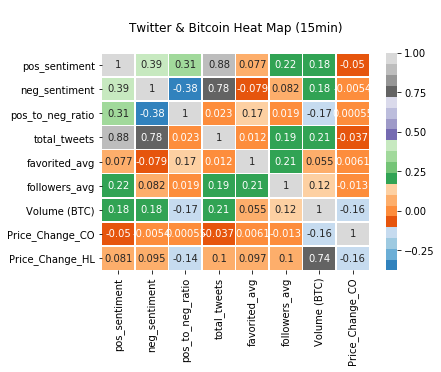

In [75]:
import seaborn as sns
#1) Running Scaled DataFrame of to Invesigate Pearson Correlation Between all Variables
pearson_15min = scaled_df.corr(method='pearson')

pearson_15min.drop('Price_Change_HL', axis=1, inplace=True)
print("\nPearson Correlation Results (15min):")
display(pearson_15min)

#2) Generating a HeatMap

print('\nHeatmap for 15min Interval:\n')
sns.heatmap(pearson_15min, cmap="tab20c", annot=True, linewidths=.5)
plt.title("\nTwitter & Bitcoin Heat Map (15min)\n ")
plt.show()


### Heatmap for 30 Min Interval

![Heatmap 30 min](./CapstoneII-Figures/Twitter_and_Bitcoin_HeatMap_30min_noHL.png)

# Part VI: Machine Learning

### Collecting All Tweets Tweeted Within a 15 Minute Interval


In [71]:
#1) Extracting tweets and time stamps from previously created dataframe
tweets_and_time_df = tweet_df[['time', 'tweet']]

# display(tweets_and_time_df.head())

#2) Setting 'time' dataframe index
tweets_and_time_df.set_index('time', inplace=True)

# display(tweets_and_time_df.head())


#3) Collecting all tweets tweeted within a 15 minute interval
tweets_and_time_15min_agg_df =tweets_and_time_df.resample('15T').agg(lambda x: ''.join(x))

print('Tweets collected into 15 minute intervals:')
display(tweets_and_time_15min_agg_df.head(1))
display(tweets_and_time_15min_agg_df.info())




Tweets collected into 15 minute intervals:


tweet
time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1179 entries, 2018-03-01 20:15:00 to 2018-03-14 02:45:00
Freq: 15T
Data columns (total 1 columns):
tweet    1179 non-null object
dtypes: object(1)
memory usage: 18.4+ KB


None

### Linking 15 Minute Intervals up With Price Change Labels


In [72]:
#1) Making Copy of Bitcoin DataFrame resampled at 15 Minute Intervals
bitcoin_15min_price_change_df=twitter_price_15min_df.copy()
# display(bitcoin_15min_price_change_df.tail())

#2) Creating Price labels for Price Changes of the 'Close' & 'Open (1=Price Increase, 0=Price Decrease)
bitcoin_15min_price_change_df['Price_Change_CO_Label'] = np.where(bitcoin_15min_price_change_df['Price_Change_CO']>=0, 1, 0)

# display(bitcoin_15min_price_change_df.head())

#3) Justing Taking Labeled Column & Timestamp
bitcoin_15min_price_change_df = bitcoin_15min_price_change_df[['Price_Change_CO_Label']]
# display(bitcoin_15min_price_change_df.head())

#4) Joining Tweets Collected Within 15 Minute Interval & Price Change Labels
collected_tweets_and_price_label_df_15min = pd.merge(tweets_and_time_15min_agg_df, bitcoin_15min_price_change_df, left_index=True, right_index=True)

display(collected_tweets_and_price_label_df_15min.info())
display(collected_tweets_and_price_label_df_15min.head(1))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1177 entries, 2018-03-01 20:15:00 to 2018-03-14 02:15:00
Data columns (total 2 columns):
tweet                    1177 non-null object
Price_Change_CO_Label    1177 non-null int64
dtypes: int64(1), object(1)
memory usage: 27.6+ KB


None

tweet  \
2018-03-01 20:15:00  pablo  escobar  clearly  used  bitcoin  to  sell  cocaine  in  the  usa  everyone  knows  that    knowyourfacts  pabloescobarcrypto  bill  miller  hedge  fund  god  bitcoin  is  an  innovation  comparable  to  electricity  the  radio  and  the  internet  want  to  know  what  coin  to  holdtcocskgobmrbtc  xlm  lbc  adx  dgb  rdd  xel  qrl  ark  nxt  block  jack  dorsey  square  will  go  further  with  bitcoin  than  buysell  option  bill  miller  hedge  fund  god  bitcoin  is  an  innovation  comparable  to  electricity  the  radio  and  the  internet  this  channel  called  dgb  before  it  made  x  they  only  share  high  reward  low  risk  signals  join  binance  is  happy  to  announce  a    reduction  in  btc  withdrawal  fees  effective  immediately  btc  withdrawal  fees  are  onl  bitcoin  is  a  stupid  way  to  try  and  make  money  because  it  not  even  an  investment  as  you  don  get  any  cash  flow  congratulations  on  your  k  subs  hope  soon  k    amaaeiwundckjcfcemwqcbwwdsoptso  just  signed  up  for  wcx  the  global  digital  currency  exchange  sign  up  amp  earn    wcx  tokens  bitcoin  light  by  name  not  by  nature  digital  currency  litecoin  has  soared  value  over  the  past  year  this  day  in    litecoin  pri  we  are  glad  to  announce  that  the  presale  has  been  closed  the  total  amount  raised  between  fiat  btc  and  eth  was  m  usd  no  news  fromnewsbtc    ripple  price  technical  analysis  can  xrpusd  make  it    condvecou    bitcoin  follow  retweet  this  competition  tweet  then  fill  in  the  form  to  get  a  random  btc  rewards  we  will  giveaway  totall  xrp  is  a  in  the  same  classification  of  currency  as  bitcoin  or  ethereum  but  using  a  protocol  that  is  m  continuing  our  daily  medium  article  today  doctailor  focuses  on  how  our  smartcontracts  platform  merges  clauses  effect  steve  wozniak    btc  in  unlikely  credit  card  fraud    btctn  venezuela  claims  petro  cryptocurrency  has  raised  bn  from  investors  in    countries  waybackwednesday    nyc  for  one  brief  moment  the  city  stopped  just  for  me  bitcoin  bloc  dominance  weather  report  bearish  mode  cause  downtrend  channel  still  active  bullish  mode  already  follow  retweet  this  competition  tweet  then  fill  in  the  form  to  get  a  random  btc  rewards  we  will  giveaway  totall  covcrlywa  to  launch  completely  renewable  cryptocurrency  mining  operation  coehwenqngw  come  to  join  a  good  project  pay  now  giving  free  airdrop  get    ppkc  first  an  if  bitcoin  were  the  mona  lisa  amp  secure    x  leverage  forex  stocks  amp  more  with  crypto    here  the  call  for  the  night  guys  this  is  a  big  one  i  give  everyone    minutes  to  buy  before  me  bntbtc  on  binan  cryptowatch  be  thankful  for  bitcoin  even  if  you  didn  get  rich  and  ev  cobbnlcrckf  btc  development  has  been  broken  down  in  to  multiple  phases    currently  release  on  regulated  bank  starts  offering  ethereum  bitcoin  bitcoin  cash  litecoin  and  ripple  tradingtcodbuymlmvrm  if  you  missed  us  live  that  feeling  when  someone  neatly  summarizes  everything  youve  been  thinking  about  but  were  too  dumb  to  articulate  korea  times  coveragewhen  comparing  bitcoin  and  bitcoin  cash  bch  was  created  to  speed  up  transactions  your  hey  i  just  received    gram  tokens  as  a  bonus  in  telegram  ico  get  yours  now  btc  eth  ltc  hey  i  just  received    gram  tokens  as  a  bonus  in  telegram  ico  get  yours  now  btc  eth  ltc  oh  shit  doctailor  bounty  bountycampaign  btc  bitcoin  ico  the  real  bubble  and  ponzi  scheme  is  the  usd  and  the  banks  that  own  the  federal  government  they  print  their  own  cryptocurrency  firms  targeted  in  sec  probe  cofcskzeosu  blockchain  cryptocurrency  crypto  btc  btcusd  et  es  un  bitcoin  la  era  de  las 

### Preparing Training & Testing Data

In [35]:
#1) Spitting Data into Training & Testing

X_train_words = collected_tweets_and_price_label_df_15min['tweet'].values[0:1000]
X_test_words = collected_tweets_and_price_label_df_15min['tweet'].values[1000:]


Y_train = collected_tweets_and_price_label_df_15min['Price_Change_CO_Label'].values[0:1000]
Y_test= collected_tweets_and_price_label_df_15min['Price_Change_CO_Label'].values[1000:]

display(Y_test)

#2) Checking to make sure numpy arrays are all same size 
print(len(X_train_words), len(Y_train),len(X_test_words), len(Y_test))

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1])

1000 1000 178 178


### Bag of Words with CountVectorizer()

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#1) Creating Bag of Words Model with CountVectorizer()

count_vectorizer = CountVectorizer(analyzer = "word",
                                   tokenizer = None, 
                                   preprocessor = None, 
                                   stop_words = 'english',
                                   ngram_range = (1,4), #uses both unigrams and bigrams to built vocab
                                   max_df =.6, #ignores terms that appear in more than 50% of the doucments
                                   min_df = .01,
                                   max_features = 100000
                                  )


#2) Fitting the data to learn vocab, and tranforming to create feature matrix (document-term matrix with raw frequencies)
count_train = count_vectorizer.fit_transform(X_train_words) #all words in xtrain make up learned vocab

count_test = count_vectorizer.transform(X_test_words)#feature matrix (raw word counts for each document -- in our case a document is the tweets collected every 15 mins)for testing data


## Viewing Word Feature Matrix as DataFrame

In [37]:
#3) Taking a look at the trained feature matrix as an array
feature_matrix_array_train = count_train.toarray()#training doc matrix and vocab
feature_matrix_array_test = count_test.toarray()#testing doc matrix

#displaying train and test feature matrices

print('Training Feature Matrix (words) Shape:',feature_matrix_array_train.shape)
print('Testing Feature Matrix (words) Shape:',feature_matrix_array_test.shape)

#4) Putting word features into a dataframe to better see whats going on

#a) DataFrame of word features for training
feature_matrix_words_df_train = pd.DataFrame(feature_matrix_array_train, columns=count_vectorizer.get_feature_names())
print("\nTraining Matrix (words):\n")
display(feature_matrix_words_df_train.tail())

#b) DataFrame of word features for testing
feature_matrix_words_df_test = pd.DataFrame(feature_matrix_array_test, columns=count_vectorizer.get_feature_names())

#resetting index to start at begiginng of testing data
feature_matrix_words_df_test.index = range(1000, 1178)

print("\nTesting Matrix (words):\n")
display(feature_matrix_words_df_test.tail())



Training Feature Matrix (words) Shape: (1000, 100000)
Testing Feature Matrix (words) Shape: (178, 100000)

Training Matrix (words):



,aa,aa rating,aa rating icobazaar,aa rating icobazaar crypto,aaj,aaj tak,aaj tak abp,aajnews,aan,aantonop,...,zurich,zurich coyvutinhgcrypto,zurich coyvutinhgcrypto cryptolottery,zurich coyvutinhgcrypto cryptolottery cryptocurrency,zurich min,zurich min questions,zurich min questions answers,zwei,zzzzz,zzzzz bitcoin
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
996,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,1,1,1,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Testing Matrix (words):



,aa,aa rating,aa rating icobazaar,aa rating icobazaar crypto,aaj,aaj tak,aaj tak abp,aajnews,aan,aantonop,...,zurich,zurich coyvutinhgcrypto,zurich coyvutinhgcrypto cryptolottery,zurich coyvutinhgcrypto cryptolottery cryptocurrency,zurich min,zurich min questions,zurich min questions answers,zwei,zzzzz,zzzzz bitcoin
1173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Adding Additonal Features to Feature Matrix 

In [73]:
#display(twitter_price_15min_df.head())
#1) Taking addtional feature columns as values
addtional_features_values = twitter_price_15min_df[['pos_to_neg_ratio','total_tweets','favorited_avg','followers_avg','Volume (BTC)']].values

#2) Creating another dataframe with data -- to avoid resetting time index in df
#additional_features_df = pd.DataFrame(addtional_features_values, columns = ['pos_to_neg_ratio','total_tweets','favorited_avg','followers_avg','Volume (BTC)'])
additional_features_df = pd.DataFrame(addtional_features_values, columns = ['POS_TO_NEG_RATIO','TOTAL_TWEETS','FAVORITED_AVG','FOLLOWERS_AVG','VOLUME (BTC)'])
print('\nAdditional Features to add:')
display(additional_features_df.head())
# display(additional_features_df.info())


Additional Features to add:


,POS_TO_NEG_RATIO,TOTAL_TWEETS,FAVORITED_AVG,FOLLOWERS_AVG,VOLUME (BTC)
0,2.909091,817.0,5754.968525,8461.403279,307.51
1,3.731707,970.0,5335.484645,6742.339475,332.25
2,3.215686,215.0,5148.629428,3415.438692,270.58
3,0.000000,0.0,0.000000,0.000000,186.92
4,3.421053,672.0,7250.560870,5844.790435,71.93


## Final X_train and X_test (15 minute Interval)

In [75]:
#3) Finally a DataFrame with All Word features and [pos_to_neg_ratio, total_tweets, Volume (BTC)]
X_train_df = pd.merge(feature_matrix_words_df_train,additional_features_df, left_index=True, right_index=True) 
X_test_df = pd.merge(feature_matrix_words_df_test,additional_features_df, left_index=True, right_index=True) 

# feature_columns = X_train_df.columns                  
X_train = X_train_df.values # Training Features and documents for 15 min intervals - Final!
X_test = X_test_df.values# Testing Features - Final!


print('This is Training DF, info, and array:\n')
# display(X_train_df.info())
display(X_train_df.head())
# display(X_train)

print('This is Testing DF, info, and array:\n')
# display(X_test_df.info())
display(X_test_df.head())
# display(X_test)




This is Training DF, info, and array:



,aa,aa rating,aa rating icobazaar,aa rating icobazaar crypto,aaj,aaj tak,aaj tak abp,aajnews,aan,aantonop,...,zurich min questions,zurich min questions answers,zwei,zzzzz,zzzzz bitcoin,POS_TO_NEG_RATIO,TOTAL_TWEETS,FAVORITED_AVG,FOLLOWERS_AVG,VOLUME (BTC)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.909091,817.0,5754.968525,8461.403279,307.51
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.731707,970.0,5335.484645,6742.339475,332.25
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.215686,215.0,5148.629428,3415.438692,270.58
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,0.0,0.000000,0.000000,186.92
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.421053,672.0,7250.560870,5844.790435,71.93


This is Testing DF, info, and array:



,aa,aa rating,aa rating icobazaar,aa rating icobazaar crypto,aaj,aaj tak,aaj tak abp,aajnews,aan,aantonop,...,zurich min questions,zurich min questions answers,zwei,zzzzz,zzzzz bitcoin,POS_TO_NEG_RATIO,TOTAL_TWEETS,FAVORITED_AVG,FOLLOWERS_AVG,VOLUME (BTC)
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4.682171,733.0,4323.627096,5724.051643,68.16
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,4.211679,714.0,4291.540667,4034.248667,133.30
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.802395,802.0,4284.660841,4085.947573,94.99
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.429630,1196.0,3242.155952,6191.909166,78.49
1004,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,4.845679,947.0,4921.016119,4621.495522,62.55


### Machine Learning Imports

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics




# Random Forest
***

###  Random Forest GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# #1) Creating parameter grid for Random Forest
# param_grid_rf = {'n_estimators' : [1000, 20000, 30000], 'max_features': ['auto', 'log2'], 'class_weight': ['balanced']}

# #2) Initializing Model
# rf_classifier = RandomForestClassifier(n_jobs =-1)

# #3) Setting up GridSearchCV
# rf_cv = GridSearchCV(rf_classifier, param_grid_rf, n_jobs=-1)

# #4) Fitting training data to model
# rf_cv.fit(X_train, Y_train)

# #5) Printing best paramters and best score
# rf_best_params = rf_cv.best_params_

# rf_best_score = rf_cv.best_score_

# print("Random Forest Classifier Best Tuned Hyper Parameters:", rf_best_params)
# print("Random Forest Classifier Best Score With Hyper Parameters:", rf_best_score)

### Optimal GridSearch Results - Random Forest
***
**15 Minute Interval:**

**1) CountVectorizer: ngram_range = (1,4), max_df =.6, min_df = .01, max_features = 100000**

Random Forest Classifier Best Tuned Hyper Parameters: {'class_weight': 'balanced', 'max_features': 'auto', 'n_estimators': 20000}
Random Forest Classifier Best Score With Hyper Parameters: 0.499

**30 Minute Interval:**

**1) CountVectorizer: ngram_range = (1,4), max_df =.6, min_df = .01, max_features = 100000**

Random Forest Classifier Best Tuned Hyper Parameters: {'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 1000}
Random Forest Classifier Best Score With Hyper Parameters: 0.506666666667


### Random Forest - Optimal Model

In [49]:
#1) Instantiating RandomForestClassifier Model w/ Optimal Parameters from GridSearchCV
opt_rf_param = {'class_weight': 'balanced', 'max_features': 'auto', 'n_estimators': 20000}

#a) Unpacking paramertes into model
opt_rf_classifier = RandomForestClassifier(**opt_rf_param, n_jobs=-1, random_state=42 )

#2) Training Model
opt_rf_classifier.fit(X_train, Y_train)

#3) Making Predictions
pred_rf_opt = opt_rf_classifier.predict(X_test)

#4) Calculating Accuracy
accuracy_rf_opt = metrics.accuracy_score(Y_test, pred_rf_opt)
print("Accuracy of Random Forest Classifier is:", accuracy_rf_opt)

#5) Confusion Matrix
confusion_matrix_rf_opt = metrics.confusion_matrix(Y_test, pred_rf_opt, labels = [0,1])
print("\nConfusion Matrix for Random Forest Classifier:\n\n", confusion_matrix_rf_opt)

Accuracy of Random Forest Classifier is: 0.522471910112

Confusion Matrix for Random Forest Classifier:

 [[82  8]
 [77 11]]


### Random Forest -- Most Important Features

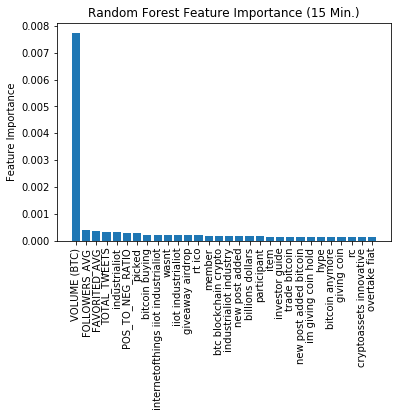

In [54]:
feat_labels = X_train_df.columns
# print(feat_labels[0:5])

importances = opt_rf_classifier.feature_importances_

indices = np.argsort(importances)[::-1]#reverses argsort


feature_num = []
feature_names = []
feature_import = []

for f in range(0,30):#X_train_df.shape[1]
    feature_num.append(f)
    feature_names.append(feat_labels[indices[f]])
    feature_import.append(importances[indices[f]])
    
    #print(f, feat_labels[indices[f]], importances[indices[f]] )

# print(feature_num)
# print(feature_names)
# print(feature_import)


plt.title('Random Forest Feature Importance (15 Min.)')
plt.bar(range(0,30), feature_import, align='center')
plt.xticks(range(0,30), feature_names, rotation =90)
plt.ylabel("Feature Importance")

plt.show()

### Random Forest Feature Importance (30 Min.)

![Random Forest 30 Min Importance](./CapstoneII-Figures/RandomForest_BestFeatures_30Min_lag.png)

# Logistic Regression
***

### Logistic Regression Tuning With GridSearch

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# #1) Creating parameter grid for Random Forest
# param_grid_lr = {'penalty' : ['l1', 'l2'], 'C': [.00001, .0001, .001, .01, 1.0, 10, 100], 'class_weight': ['balanced']}

# #2) Initializing Model
# lr_classifier = LogisticRegression(random_state=42)

# #3) Setting up GridSearchCV
# lr_cv = GridSearchCV(lr_classifier, param_grid_lr, n_jobs=-1)

# #4) Fitting training data to model
# lr_cv.fit(count_train, Y_train)

# #5) Printing best paramters and best score
# lr_best_params = lr_cv.best_params_

# lr_best_score = lr_cv.best_score_

# print("Logistic Regression Best Tuned Hyper Parameters:", lr_best_params)
# print("Logistic Regression Best Score With Hyper Parameters:", lr_best_score)

### Optimal GridSearch Results - Logistic Regression
***

**15 Minute Interval:**

**1) CountVectorizer: ngram_range = (1,4), max_df =.6, min_df = .01, max_features = 100000**

Logistic Regression Best Tuned Hyper Parameters: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1'}
Logistic Regression Best Score With Hyper Parameters: 0.519


**30 Minute Interval:**

**1) CountVectorizer: ngram_range = (1,4), max_df =.6, min_df = .01, max_features = 100000**

Logistic Regression Best Tuned Hyper Parameters: {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l1'}
Logistic Regression Best Score With Hyper Parameters: 0.506666666667


### Logistic Regression - Optimal Model

In [52]:
#1) Instantiating Logistic Regression Mocel w/ Optimal Paramaters from GridSearchCV
opt_lr_param = {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1'}

#a) Unpacking parameters into model
opt_lr_classifier = LogisticRegression(**opt_lr_param, random_state=42)

#2) Training Model
opt_lr_classifier.fit(X_train, Y_train)

#3) Making Predictions
pred_lr_opt = opt_lr_classifier.predict(X_test)

#4) Calculating Accuracy
accuracy_lr_opt = metrics.accuracy_score(Y_test, pred_lr_opt)
print("Accuracy of Logistic Regression is:", accuracy_lr_opt)

#5) Confusion Matrix
confusion_matrix_lr_opt = metrics.confusion_matrix(Y_test, pred_lr_opt, labels = [0,1])
print("\nConfusion Matrix for Logistic Regression:\n\n", confusion_matrix_lr_opt)


Accuracy of Logistic Regression is: 0.511235955056

Confusion Matrix for Logistic Regression:

 [[43 47]
 [40 48]]


# ROC Curve

0.518055555556
0.511616161616


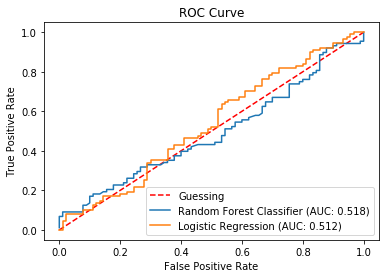

In [53]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#1) Calculating Area Under ROC Curve

#a) Random Forest Classifier
auc_roc_rf = roc_auc_score(Y_test, pred_rf_opt)
print(auc_roc_rf)

#b) Logisitic regression
auc_roc_lr = roc_auc_score(Y_test, pred_lr_opt)
print(auc_roc_lr)

#2) ROC Curve

#a)Random Forest Classifier
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, opt_rf_classifier.predict_proba(X_test)[:,1])

#b) Logisitc Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, opt_lr_classifier.predict_proba(X_test)[:,1])


plt.figure()
plt.plot([0,1], [0,1], 'r--', label='Guessing') #Line showing what guessing would yield


plt.plot(fpr_rf, tpr_rf, label='Random Forest Classifier (AUC: {})'.format(round(auc_roc_rf,3))) #Random Forest
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC: {})'.format(round(auc_roc_lr,3))) #Logistic Reg.

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc='best')



plt.show()

### ROC 30 Minute

![ROC 30 Minute](./CapstoneII-Figures/ROC_30Min_Twitter_and_Bitcoin_lag.png)

# Conclusion
***

**Please note that this code was also used to run the 30 minute scenario**
***

**Pearson Correlation**

* Evident that slightly more signal was picked up over 15 minute window (comparing heat-maps) to predict price movements

**Machine Leaning**

**Overview**
* Random Forest Classifier & Logistic Regression
* 75 – 25 split for training and testing
* Models limited to 10,005 features due to computational limits of local machine
* Features composed of words from tweets (emoji's were stripped) & price data for Bitcoin

**Performance**
* Model performance evaluated with GridSearchCV & Area Under ROC
* Random Forest attained maximum AUC of .518 over 15 minute window

**Verdict**
* At this point in time, models offer weak advantage over guessing, further research warranted!



# Road Ahead
***

* Collect twitter data for extended period of time (i.e., more than 2 weeks)

* Investigate and integrate alternate news sources into analysis

* Include emoji’s in sentiment classification and as tokenized features 

* Emoji's are structured and universal, allowing for screening of tweets in all languages

* Further investigate feature lag on different time scales to predict up or down movements

* Combine multiple machine learning models and use majority voting to increase stability in predictions